In [1]:
!pip install pypulseq==1.3.1.post1 &> /dev/null
!pip install MRzeroCore &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null

(EPI_2D_seq)=
# 2D EPI

Timing check passed successfully


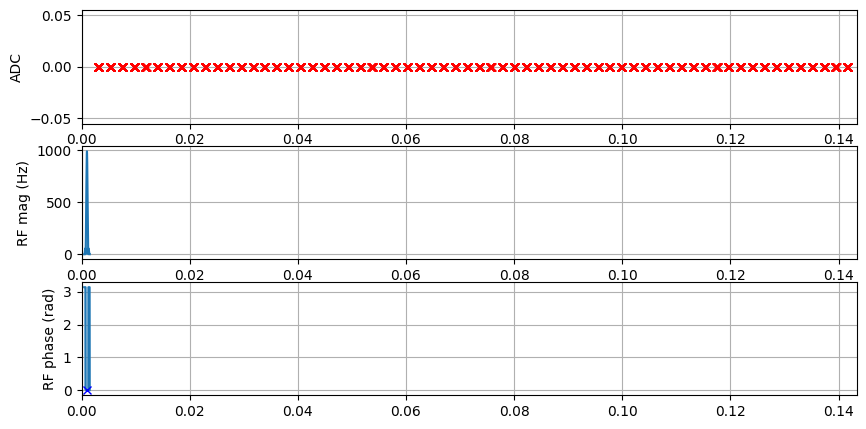

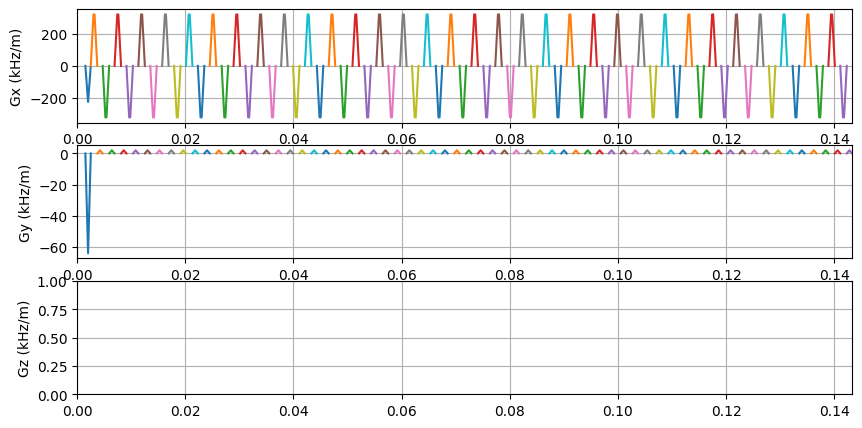

VoxelGridPhantom
FOV: base * rel = tensor([0.2000, 0.2000, 0.0080]) * tensor([1., 1., 1.]) = tensor([0.2000, 0.2000, 0.0080])


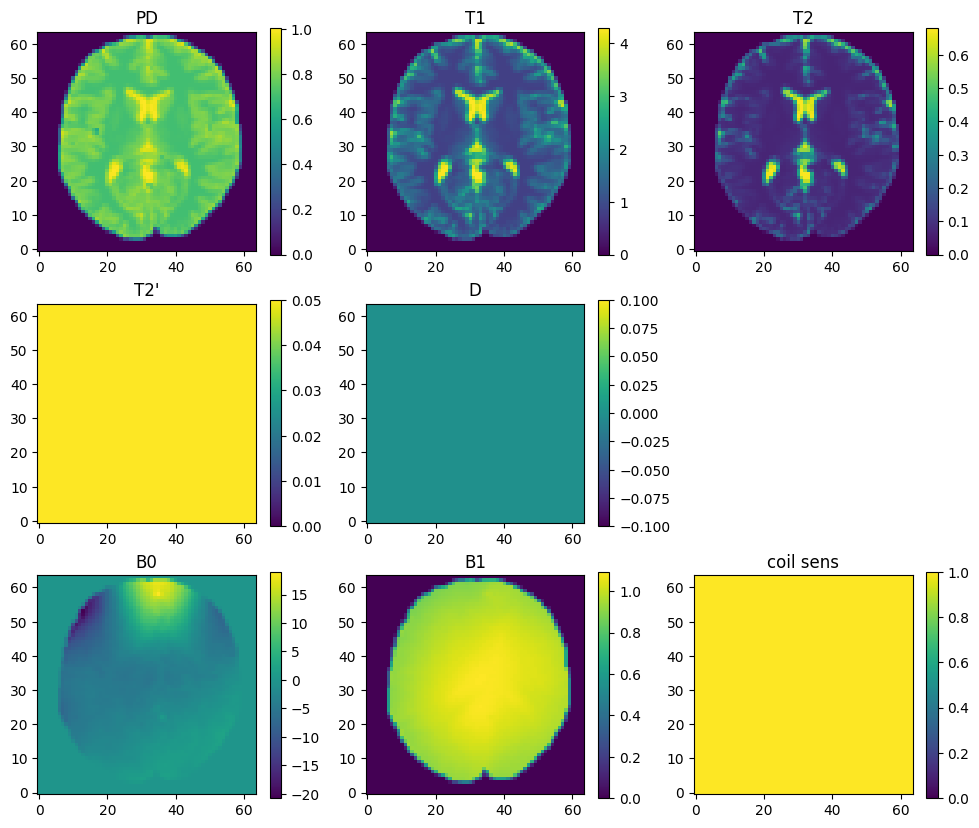

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.10/dist-packages/MRzeroCore/phantom/voxel_grid_phantom.py:154: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(shape, device=self.PD.device) / 2 / fov,


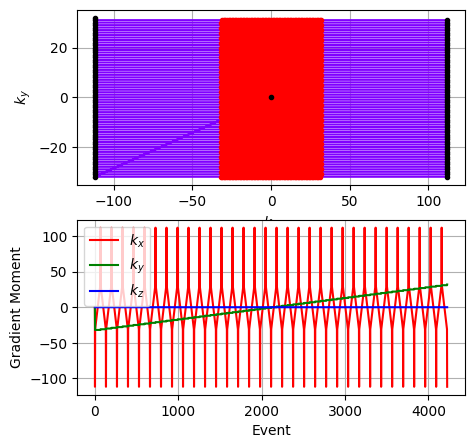

Calculating repetition 1 / 1 - done


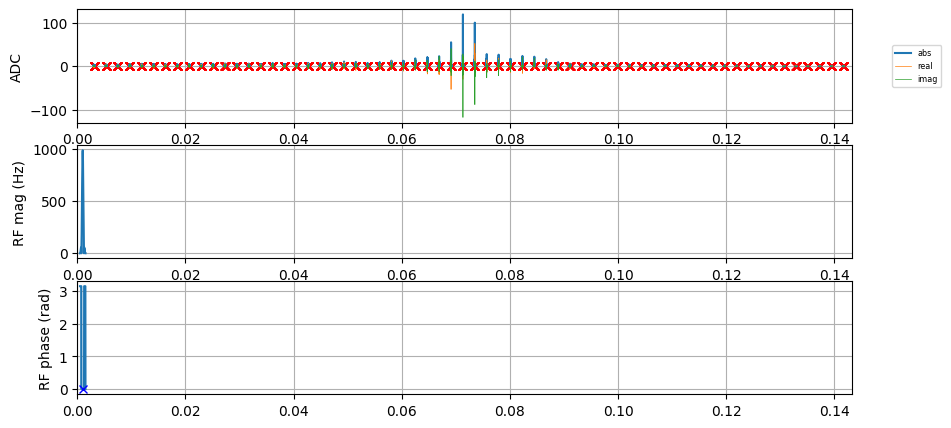

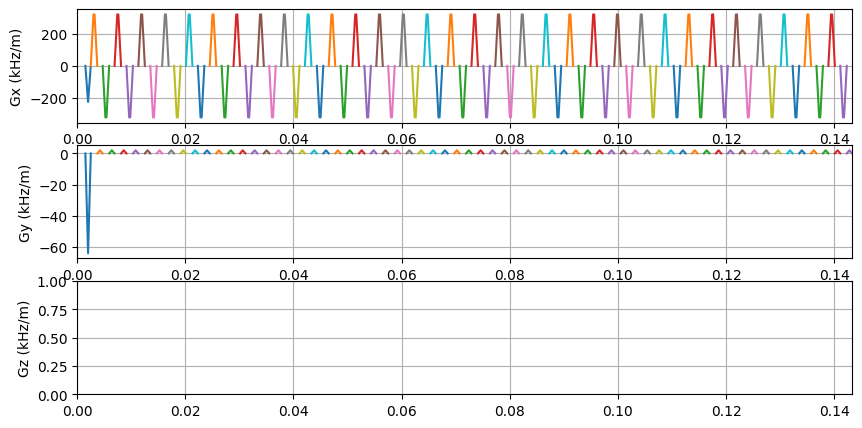

<ipython-input-2-cf5de46821a9>:162: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(kspace.numpy())))


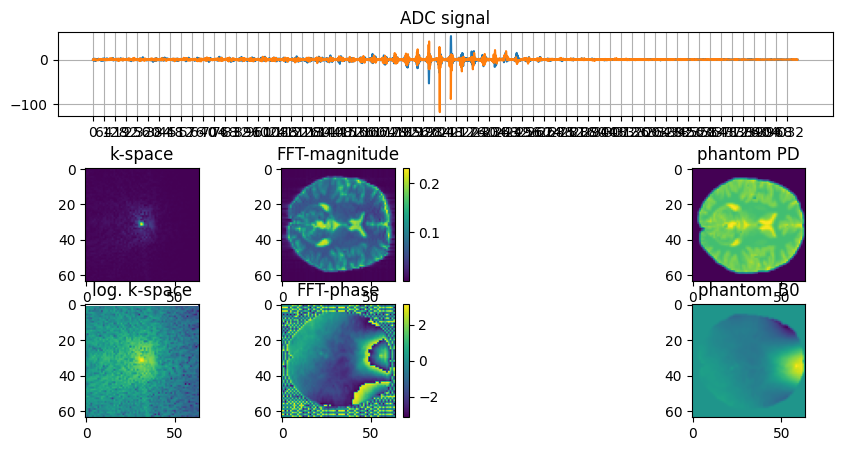

In [2]:
import numpy as np
# newer numpy versions don't contain this, but pypulseq still relies on it
np.int = int
np.float = float
np.complex = complex

import MRzeroCore as mr0
import pypulseq as pp
import torch
import matplotlib.pyplot as plt
import util

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

experiment_id = 'exB09_GRE_EPI_2D'


# %% S1. SETUP sys

# choose the scanner limits
system = pp.Opts(
    max_grad=28, grad_unit='mT/m', max_slew=150, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=50 * 10e-6
)


# %% S2. DEFINE the sequence
seq = pp.Sequence()

# Define FOV and resolution
fov = 1000e-3
slice_thickness = 8e-3
sz = (64, 64)   # spin system size / resolution
Nread = 64    # frequency encoding steps/samples
Nphase = 64    # phase encoding steps/samples

# Define rf events
rf1, _, _ = pp.make_sinc_pulse(
    flip_angle=90 * np.pi / 180, duration=1e-3,
    slice_thickness=slice_thickness, apodization=0.5, time_bw_product=4,
    system=system, return_gz=True
)
# rf1 = pp.make_block_pulse(flip_angle=90 * np.pi / 180, duration=1e-3, system=system)

# Define other gradients and ADC events
gx = pp.make_trapezoid(channel='x', flat_area=Nread, flat_time=0.2e-3, system=system)
gx_ = pp.make_trapezoid(channel='x', flat_area=-Nread, flat_time=0.2e-3, system=system)
adc = pp.make_adc(num_samples=Nread, duration=0.2e-3, phase_offset=0 * np.pi / 180, delay=gx.rise_time, system=system)
gx_pre = pp.make_trapezoid(channel='x', area=-gx.area / 2, duration=1e-3, system=system)

# ======
# CONSTRUCT SEQUENCE
# ======

gp_blip = pp.make_trapezoid(channel='y', area=1, duration=1e-3, system=system)

seq.add_block(rf1)
gp = pp.make_trapezoid(channel='y', area=-Nphase//2, duration=1e-3, system=system)
seq.add_block(gx_pre, gp)

for ii in range(0, Nphase//2):  # e.g. -64:63
    seq.add_block(gx,adc)
    seq.add_block(gp_blip)
    seq.add_block(gx_,adc)
    seq.add_block(gp_blip)



    # seq.add_block(adc, gx)
    # gp = pp.make_trapezoid(channel='y', area=-phase_enc_gradmoms[ii], duration=5e-3, system=system)
    # seq.add_block(gx_spoil, gp)


# %% S3. CHECK, PLOT and WRITE the sequence  as .seq
# Check whether the timing of the sequence is correct
ok, error_report = seq.check_timing()
if ok:
    print('Timing check passed successfully')
else:
    print('Timing check failed. Error listing follows:')
    [print(e) for e in error_report]

# PLOT sequence
sp_adc, t_adc = util.pulseq_plot(seq, clear=False, figid=(11,12))

# Prepare the sequence output for the scanner
seq.set_definition('FOV', [fov, fov, slice_thickness])
seq.set_definition('Name', 'gre')
seq.write(experiment_id + '.seq')


# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence external.seq from above
sz = [64, 64]

# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.T2dash[:] = 50e-3  # T2*=30ms
obj_p.D *= 0
obj_p.B0 *= 0.5    # alter the B0 inhomogeneity
# Store PD for comparison
PD = obj_p.PD
B0 = obj_p.B0

obj_p.plot()
# Convert Phantom into simulation data
obj_p = obj_p.build()


# %% S5:. SIMULATE  the external.seq file and add acquired signal to ADC plot

# Read in the sequence
seq0 = mr0.Sequence.from_seq_file(experiment_id + '.seq')
seq0.plot_kspace_trajectory()
# Simulate the sequence
graph = mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal = mr0.execute_graph(graph, seq0, obj_p)

# PLOT sequence with signal in the ADC subplot
plt.close(11);plt.close(12)
sp_adc, t_adc = util.pulseq_plot(seq, clear=False, signal=signal.numpy())




# %% S6: MR IMAGE RECON of signal ::: #####################################
fig = plt.figure()  # fig.clf()
plt.subplot(411)
plt.title('ADC signal')
kspace_adc = torch.reshape((signal), (Nphase, Nread)).clone().t()
plt.plot(torch.real(signal), label='real')
plt.plot(torch.imag(signal), label='imag')

kspace = kspace_adc

kspace[1:,0::2] = torch.flip(kspace[:,0::2],[0] )[:-1,:]
kspace[0,0::2,]=0

# kspace[:, ::2] = kspace[::-1, ::2]
# kspace[1:, ::2] = kspace[:-1, ::2]
# kspace[0,::2]=0

# this adds ticks at the correct position szread
major_ticks = np.arange(0, Nphase * Nread, Nread)
ax = plt.gca()
ax.set_xticks(major_ticks)
ax.grid()

# fftshift
spectrum = torch.fft.fftshift(kspace)
# FFT
space = torch.fft.ifft2(spectrum)
# fftshift
space = torch.fft.ifftshift(space)


plt.subplot(345)
plt.title('k-space')
plt.imshow((np.abs(kspace_adc.numpy())))
plt.subplot(349)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace.numpy())))

plt.subplot(346)
plt.title('FFT-magnitude')
plt.imshow(np.abs(space.numpy()))
plt.colorbar()
plt.subplot(3, 4, 10)
plt.title('FFT-phase')
plt.imshow(np.angle(space.numpy()), vmin=-np.pi, vmax=np.pi)
plt.colorbar()

# % compare with original phantom obj_p.PD
plt.subplot(348)
plt.title('phantom PD')
plt.imshow(PD)
plt.subplot(3, 4, 12)
plt.title('phantom B0')
plt.imshow(B0)

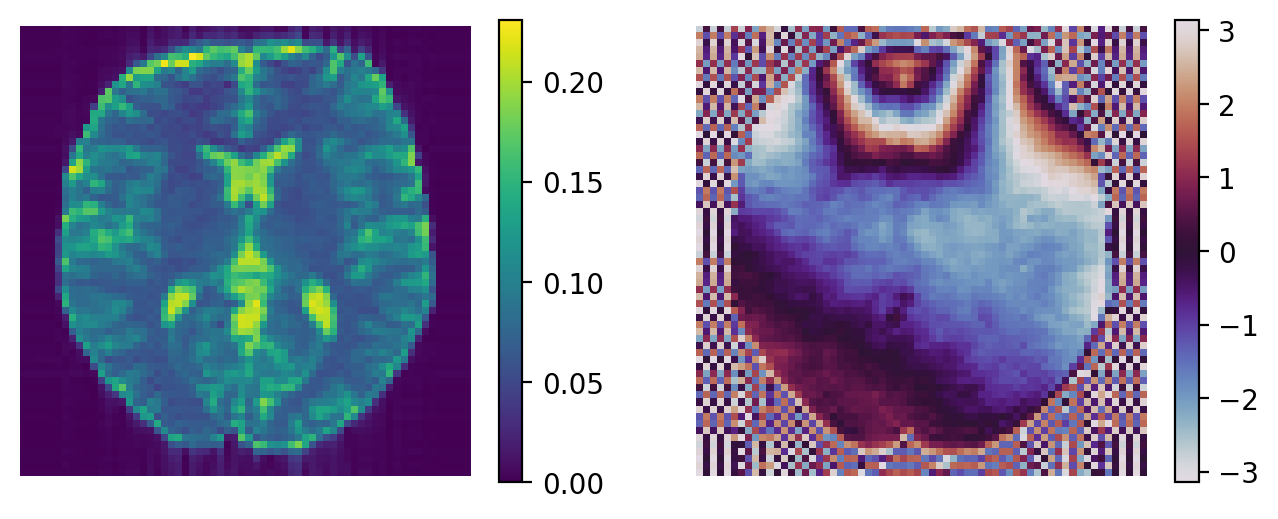

In [ ]:
plt.figure(figsize=(8, 3), dpi=200)
plt.subplot(121)
plt.imshow(space.abs().T, origin="lower", vmin=0)
plt.colorbar()
plt.axis("off")
plt.subplot(122)
plt.imshow(space.angle().T, origin="lower", vmin=-np.pi, vmax=np.pi, cmap="twilight")
plt.colorbar()
plt.axis("off")
plt.show()